# Predicting Housing Prices



In [2]:
import numpy as np
from sklearn import linear_model as lm


import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12


# The Data

The [Ames dataset](http://jse.amstat.org/v19n3/decock.pdf) consists of 2930 records taken from the Ames, Iowa, Assessor’s Office describing houses sold in Ames from 2006 to 2010.  The data set has 23 nominal, 23 ordinal, 14 discrete, and 20 continuous variables (and 2 additional observation identifiers) --- 82 features in total. The information was used in computing assessed values for individual residential properties sold in Ames, Iowa from 2006 to 2010.

The data are split into training and test sets with 2000 and 930 observations, respectively.

In [3]:
training_data = pd.read_csv("ames_train.csv")
test_data = pd.read_csv("ames_test.csv")

As a good sanity check, we should at least verify that the data shape matches the description.

In [4]:
# 2000 observations and 82 features in training data
assert training_data.shape == (2000, 82)
# 930 observations and 81 features in test data
assert test_data.shape == (930, 81)
# SalePrice is hidden in the test data
assert 'SalePrice' not in test_data.columns.values
# Every other column in the test data should be in the training data
assert len(np.intersect1d(test_data.columns.values, 
                          training_data.columns.values)) == 81

The next order of business is getting a feel for the variables in our data.  The Ames data set contains information that typical homebuyers would want to know.  


In [5]:
training_data.columns.values

array(['Order', 'PID', 'MS_SubClass', 'MS_Zoning', 'Lot_Frontage',
       'Lot_Area', 'Street', 'Alley', 'Lot_Shape', 'Land_Contour',
       'Utilities', 'Lot_Config', 'Land_Slope', 'Neighborhood',
       'Condition_1', 'Condition_2', 'Bldg_Type', 'House_Style',
       'Overall_Qual', 'Overall_Cond', 'Year_Built', 'Year_Remod/Add',
       'Roof_Style', 'Roof_Matl', 'Exterior_1st', 'Exterior_2nd',
       'Mas_Vnr_Type', 'Mas_Vnr_Area', 'Exter_Qual', 'Exter_Cond',
       'Foundation', 'Bsmt_Qual', 'Bsmt_Cond', 'Bsmt_Exposure',
       'BsmtFin_Type_1', 'BsmtFin_SF_1', 'BsmtFin_Type_2', 'BsmtFin_SF_2',
       'Bsmt_Unf_SF', 'Total_Bsmt_SF', 'Heating', 'Heating_QC',
       'Central_Air', 'Electrical', '1st_Flr_SF', '2nd_Flr_SF',
       'Low_Qual_Fin_SF', 'Gr_Liv_Area', 'Bsmt_Full_Bath',
       'Bsmt_Half_Bath', 'Full_Bath', 'Half_Bath', 'Bedroom_AbvGr',
       'Kitchen_AbvGr', 'Kitchen_Qual', 'TotRms_AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace_Qu', 'Garage_Type', 'Garage_Yr_Blt',

# Part 1: Exploratory Data Analysis

In this section, we will make a series of exploratory visualizations and interpret them.


### Sale Price
We begin by examining a [raincloud plot](https://micahallen.org/2018/03/15/introducing-raincloud-plots/amp/?__twitter_impression=true) (a combination of a KDE, a histogram, a strip plot, and a box plot) of our target variable `SalePrice`.  At the same time, we also take a look at some descriptive statistics of this variable.

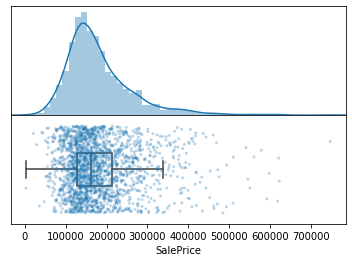

In [6]:
fig, axs = plt.subplots(nrows=2)

sns.distplot(
    training_data['SalePrice'], 
    ax=axs[0]
)
sns.stripplot(
    training_data['SalePrice'], 
    jitter=0.4, 
    size=3,
    ax=axs[1],
    alpha=0.3
)
sns.boxplot(
    training_data['SalePrice'],
    width=0.3, 
    ax=axs[1],
    showfliers=False,
)

# Align axes
spacer = np.max(training_data['SalePrice']) * 0.05
xmin = np.min(training_data['SalePrice']) - spacer
xmax = np.max(training_data['SalePrice']) + spacer
axs[0].set_xlim((xmin, xmax))
axs[1].set_xlim((xmin, xmax))

# Remove some axis text
axs[0].xaxis.set_visible(False)
axs[0].yaxis.set_visible(False)
axs[1].yaxis.set_visible(False)

# Put the two plots together
plt.subplots_adjust(hspace=0)

# Adjust boxplot fill to be white
axs[1].artists[0].set_facecolor('white')

In [7]:
training_data['SalePrice'].describe()

count      2000.000000
mean     180775.897500
std       81581.671741
min        2489.000000
25%      128600.000000
50%      162000.000000
75%      213125.000000
max      747800.000000
Name: SalePrice, dtype: float64

### SalePrice vs Gr_Liv_Area

Next, we visualize the association between `SalePrice` and `Gr_Liv_Area`.  The `codebook.txt` file tells us that `Gr_Liv_Area` measures "above grade (ground) living area square feet."

This variable represents the square footage of the house excluding anything underground.  Some additional research (into real estate conventions) reveals that this value also excludes the garage space.

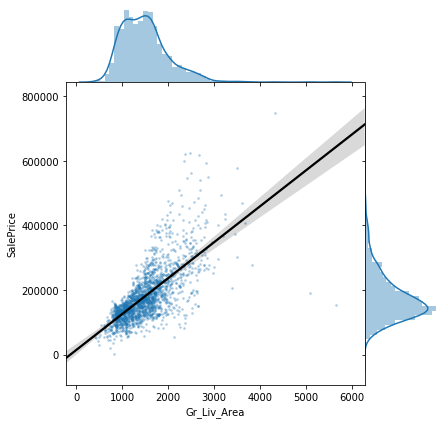

In [10]:
sns.jointplot(
    x='Gr_Liv_Area', 
    y='SalePrice', 
    data=training_data,
    stat_func=None,
    kind="reg",
    ratio=4,
    space=0,
    scatter_kws={
        's': 3,
        'alpha': 0.25
    },
    line_kws={
        'color': 'black'
    }
);

There's certainly an association, and perhaps it's linear, but the spread is wider at larger values of both variables.  Also, there are two particularly suspicious houses above 5000 square feet that look too inexpensive for their size.


What are the Parcel Indentification Numbers for the two houses with `Gr_Liv_Area` greater than 5000 sqft?


In [11]:
training_data.head()
training_data[training_data['Gr_Liv_Area'] > 5000]
q2house1 = 908154235
q2house2 = 908154195




The codebook tells us how to manually inspect the houses using an online database called Beacon. These two houses are true outliers in this data set: they aren't the same time of entity as the rest. They were partial sales, priced far below market value. If you would like to inspect the valuations, follow the directions at the bottom of the codebook to access Beacon and look up houses by PID.

For this assignment, we will remove these outliers from the data. 


In [13]:
def remove_outliers(data, variable, lower=-np.inf, upper=np.inf):
    """
    Input:
      data (data frame): the table to be filtered
      variable (string): the column with numerical outliers
      lower (numeric): observations with values lower than this will be removed
      upper (numeric): observations with values higher than this will be removed
    
    Output:
      a winsorized data frame with outliers removed
      
    Note: This function should not change mutate the contents of data.
    """
    v = variable
    df = data
    df = df[df[v] >= lower]
    df = df[df[v] <= upper]
    return df

training_data = remove_outliers(training_data, 'Gr_Liv_Area', upper=5000)

# Part 2: Feature Engineering

In this section we will create a new feature out of existing ones through a simple data transformation.

### Bathrooms

Let's create a groundbreaking new feature. Due to recent advances in Universal WC Enumeration Theory, we now know that Total Bathrooms can be calculated as:

$$ \text{TotalBathrooms}=(\text{BsmtFullBath} + \text{FullBath}) + \dfrac{1}{2}(\text{BsmtHalfBath} + \text{HalfBath})$$



In [15]:
def add_total_bathrooms(data):
    """
    Input:
      data (data frame): a data frame containing at least 4 numeric columns 
            Bsmt_Full_Bath, Full_Bath, Bsmt_Half_Bath, and Half_Bath
    """
    with_bathrooms = data.copy()
    bath_vars = ['Bsmt_Full_Bath', 'Full_Bath', 'Bsmt_Half_Bath', 'Half_Bath']
    weights = pd.Series([1, 1, 0.5, 0.5], index=bath_vars)
    
    intermediate = with_bathrooms[bath_vars].mul(weights)
    
    
    with_bathrooms['TotalBathrooms'] = intermediate.sum(axis = 1)
    return with_bathrooms

training_data = add_total_bathrooms(training_data)

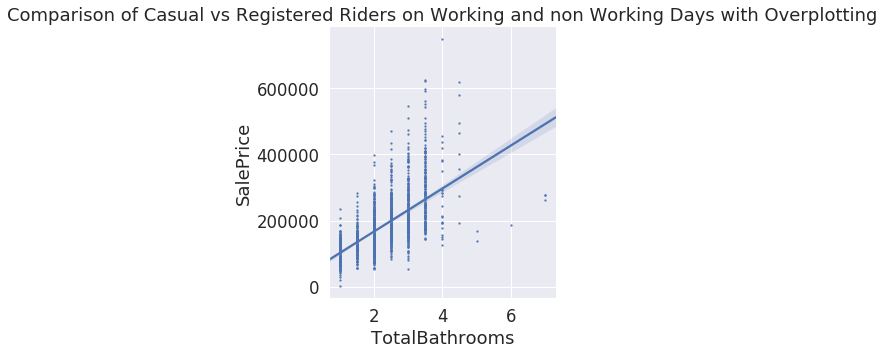

In [17]:
sns.set(font_scale = 1.5)
sns.lmplot(x = 'TotalBathrooms', y = 'SalePrice', data = training_data, scatter_kws={"s":1.90})
plt.title('Comparison of Casual vs Registered Riders on Working and non Working Days with Overplotting');

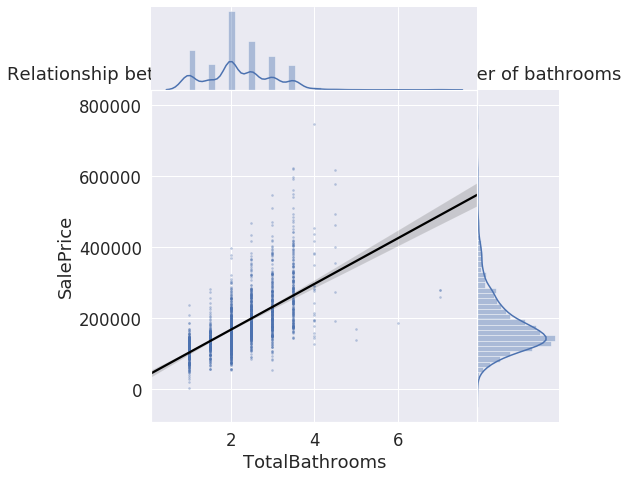

In [18]:
sns.jointplot(
    x='TotalBathrooms', 
    y='SalePrice', 
    data=training_data,
    stat_func=None,
    height = 7,
    kind="reg",
    ratio=4,
    space=0,
    scatter_kws={
        's': 3,
        'alpha': 0.25
    },
    line_kws={
        'color': 'black'
    }
)



plt.title('Relationship between Sale Price and the total number of bathrooms', pad = 10);

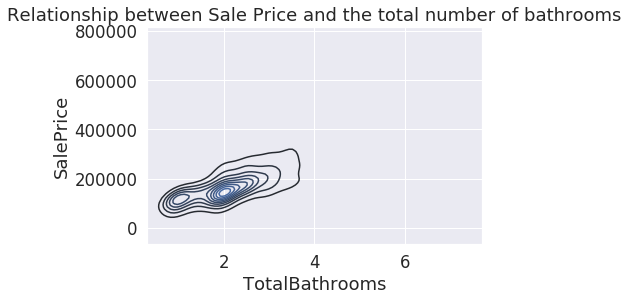

In [19]:
sns.kdeplot(training_data['TotalBathrooms'], training_data['SalePrice'])
plt.title('Relationship between Sale Price and the total number of bathrooms');

# Part 3: Modeling

We've reached the point where we can specify a model. But first, we will load a fresh copy of the data, just in case our code above produced any undesired side-effects. Run the cell below to store a fresh copy of the data from `ames_train.csv` in a dataframe named `full_data`. We will also store the number of rows in `full_data` in the variable `full_data_len`.

In [20]:
# Load a fresh copy of the data and get its length
full_data = pd.read_csv("ames_train.csv")
full_data_len = len(full_data)
full_data.head()

Order        PID  MS_SubClass MS_Zoning  Lot_Frontage  Lot_Area Street  \
0      1  526301100           20        RL         141.0     31770   Pave   
1      2  526350040           20        RH          80.0     11622   Pave   
2      3  526351010           20        RL          81.0     14267   Pave   
3      4  526353030           20        RL          93.0     11160   Pave   
4      5  527105010           60        RL          74.0     13830   Pave   

  Alley Lot_Shape Land_Contour  ... Pool_Area Pool_QC  Fence Misc_Feature  \
0   NaN       IR1          Lvl  ...         0     NaN    NaN          NaN   
1   NaN       Reg          Lvl  ...         0     NaN  MnPrv          NaN   
2   NaN       IR1          Lvl  ...         0     NaN    NaN         Gar2   
3   NaN       Reg          Lvl  ...         0     NaN    NaN          NaN   
4   NaN       IR1          Lvl  ...         0     NaN  MnPrv          NaN   

  Misc_Val Mo_Sold Yr_Sold Sale_Type  Sale_Condition  SalePrice  
0        0       5    2010        WD          Normal     204900  
1        0       6    2010        WD          Normal      95300  
2    12500       6    2010        WD          Normal     181900  
3        0       4    2010        WD          Normal     254100  
4        0       3    2010        WD          Normal     199700  

[5 rows x 82 columns]

In [21]:
full_data_len*0.8

1600.0


Now, let's split the data set into a training set and test set. We will use the training set to fit our model's parameters, and we will use the test set to estimate how well our model will perform on unseen data drawn from the same distribution. If we used all the data to fit our model, we would not have a way to estimate model performance on unseen data.


In [22]:
# This makes the train-test split in this section reproducible across different runs 
# of the notebook. You do not need this line to run train_test_split in general
np.random.seed(1337)
shuffled_indices = np.random.permutation(full_data_len)

# Set train_indices to the first 80% of shuffled_indices and and test_indices to the rest.
train_indices = shuffled_indices[:1600]
test_indices = shuffled_indices[1600:]

# Create train and test` by indexing into `full_data` using 
# `train_indices` and `test_indices`
train = full_data.loc[train_indices]
test = full_data.loc[test_indices]

### Reusable Pipeline

Throughout this assignment, you should notice that your data flows through a single processing pipeline several times.  

In [24]:
def select_columns(data, *columns):
    """Select only columns passed as arguments."""
    return data.loc[:, columns]

def process_data_gm(data):
    """Process the data for a guided model."""
    data = remove_outliers(data, 'Gr_Liv_Area', upper=5000)
    
    # Transform Data, Select Features
    data = add_total_bathrooms(data)
    data = select_columns(data, 
                          'SalePrice', 
                          'Gr_Liv_Area', 
                          'Garage_Area',
                          'TotalBathrooms',
                         )
    
    # Return predictors and response variables separately
    X = data.drop(['SalePrice'], axis = 1)
    y = data.loc[:, 'SalePrice']
    
    return X, y

Now, we can use `process_data_gm1` to clean our data, select features, and add our `TotalBathrooms` feature all in one step! This function also splits our data into `X`, a matrix of features, and `y`, a vector of sale prices. 


In [25]:
# Pre-process our training and test data in exactly the same way
# Our functions make this very easy!
X_train, y_train = process_data_gm(train)
X_test, y_test = process_data_gm(test)

### Fitting Our First Model

We are finally going to fit a model!  The model we will fit can be written as follows:

$$\text{SalePrice} = \theta_0 + \theta_1 \cdot \text{Gr_Liv_Area} + \theta_2 \cdot \text{Garage_Area} + \theta_3 \cdot \text{TotalBathrooms}$$

In vector notation, the same equation would be written:

$$y = \vec\theta \cdot \vec{x}$$

where $y$ is the SalePrice, $\vec\theta$ is a vector of all fitted weights, and $\vec{x}$ contains a 1 for the bias followed by each of the feature values.

**Note:** Notice that all of our variables are continuous, except for `TotalBathrooms`, which takes on discrete ordered values (0, 0.5, 1, 1.5, ...). 


We will use a [`sklearn.linear_model.LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) object as our linear model. In the cell below, create a `LinearRegression` object and name it `linear_model`.


In [26]:
from sklearn import linear_model as lm

linear_model = lm.LinearRegression(fit_intercept = True)

In [28]:
linear_model.fit(X_train, y_train)
y_fitted = linear_model.predict(X_train)
y_predicted = linear_model.predict(X_test)


Let's measure the quality of our model by calculating the Root-Mean-Square Error (RMSE) between our predicted house prices and the true prices stored in `SalePrice`.

$$\text{RMSE} = \sqrt{\dfrac{\sum_{\text{houses in test set}}(\text{actual price of house} - \text{predicted price of house})^2}{\text{# of houses in data set}}}$$

In [30]:
def rmse(actual, predicted):
    """
    Calculates RMSE from actual and predicted values
    Input:
      actual (1D array): vector of actual values
      predicted (1D array): vector of predicted/fitted values
    Output:
      a float, the root-mean square error
    """
    return np.sqrt(np.mean((actual - predicted)**2))


In [32]:
training_error = rmse(y_train, y_fitted)
test_error = rmse(y_test, y_predicted)
(training_error, test_error)

(46710.597505875856, 46146.64265682625)

In [34]:
# For Personal Verification


from sklearn.metrics import mean_squared_error

tr = mean_squared_error(y_train, y_fitted)
te = mean_squared_error(y_test, y_predicted)

In [35]:
(tr, te)

(2181879919.3559356, 2129512628.4968157)

In [36]:
def process_data_gm2(data):
    """Process the data for a guided model."""
    data = remove_outliers(data, 'Gr_Liv_Area', upper=5000)
    
    # Transform Data, Select Features
    data = add_total_bathrooms(data)
    data = select_columns(data, 
                          'SalePrice', 
                          'Gr_Liv_Area', 
                          'Garage_Area',
                         )
    
    # Return predictors and response variables separately
    X = data.drop(['SalePrice'], axis = 1)
    y = data.loc[:, 'SalePrice']
    
    return X, y

In [37]:
# Pre-process our training and test data in exactly the same way
# Our functions make this very easy!
X_train, y_train = process_data_gm2(train)
X_test, y_test = process_data_gm2(test)

In [38]:
from sklearn import linear_model as lm

linear_model = lm.LinearRegression(fit_intercept = True)

In [39]:
linear_model.fit(X_train, y_train)
y_fitted = linear_model.predict(X_train)
y_predicted = linear_model.predict(X_test)

In [40]:
training_error_no_bath = rmse(y_train, y_fitted)
test_error_no_bath = rmse(y_test, y_predicted)
(training_error, test_error)

(46710.597505875856, 46146.64265682625)

In [41]:
test_error_difference = test_error_no_bath - test_error
test_error_difference

2477.008463647042

### Residual Plots

One way of understanding the performance (and appropriateness) of a model is through a residual plot. Run the cell below to plot the actual sale prices against the residuals of the model for the test data.

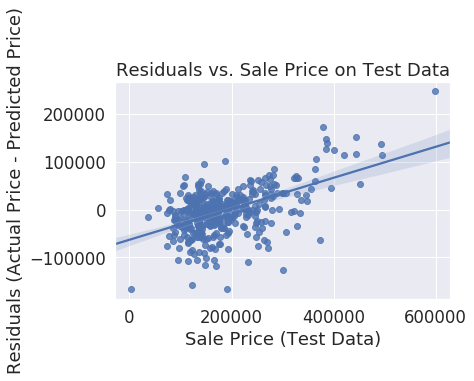

In [43]:
residuals = y_test - y_predicted
ax = sns.regplot(y_test, residuals)
ax.set_xlabel('Sale Price (Test Data)')
ax.set_ylabel('Residuals (Actual Price - Predicted Price)')
ax.set_title("Residuals vs. Sale Price on Test Data");

Ideally, we would see a horizontal line of points at 0 (perfect prediction!). The next best thing would be a homogenous set of points centered at 0. 

But alas, our simple model is probably too simple. The most expensive homes are systematically more expensive than our prediction. 

1) We could add more features. As mentioned above our model was too simple because there are probably more variables that affect the price of homes. This could be accounted for instinctively by using more of the columns present in the dataset or even other features we derive using the data that might make sense intrinsically. For example, instinctively it is safe to conclude that the location of a home adds tremendous value to its sales price. This is something we havent accounted for in the model. A feature that perhaps uses the address features present in the data or even ZIP codes could benifit the model greatly. 

2) Feature Scaling and/or Normalization - Checking the scales of our 2 features Gr_Liv_Area and Garage_Area we with our feature of TotalBathrooms, we notice that they differ on more than 3 orders of magnitude. Therefore our area features will end up dominating our other feature of total bathrooms in Logistic Regression. We can normalize all our features to the same scale before putting them in a machine learning model. This can be further extended to all other features we plan to incorporate into the final machine learning model. 

3) Hyperparameter Tuning - Grid Search - We can improve our accuracy by performing a Grid Search to tune the hyperparameters of our model. For example in case of LogisticRegression, the parameter C is the hyperparameter that we can tune.